In [2]:
from google.colab import drive
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Libraries

In [4]:
!sudo apt-get install -y xvfb ffmpeg x11-utils
!pip install -q 'gym==0.10.11'
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay
!pip install -q tf-agents
!pip install -q pygame

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 990 kB of archives.
After this operation, 3,058 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libxxf86dga1 amd64 2:1.1.5-0ubuntu1 [12.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 x11-utils amd64 7.7+5 [199 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 xvfb amd64 2:1.20.13-1ubuntu1~20.04.6 [780 kB]
Fetched 990 kB in 0s (7,711 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling b

In [5]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [6]:
tf.__version__

'2.11.0'

# Hyperparameters

In [9]:
# How long should training run?
num_iterations = 20000

# How many initial random steps, before training start, to
# collect initial data.
initial_collect_steps = 1000
# How many steps should we run each iteration to collect
# data from.
collect_steps_per_iteration = 1
# How much data should we store for training examples.
replay_buffer_max_length = 100000

batch_size = 64

learning_rate = 1e-3
# How often should the program provide an update.
log_interval = 200

# How many episodes should the program use for each evaluation.
num_eval_episodes = 10
# How often should an evaluation occur.
eval_interval = 1000


# Environment

In [10]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

In [12]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

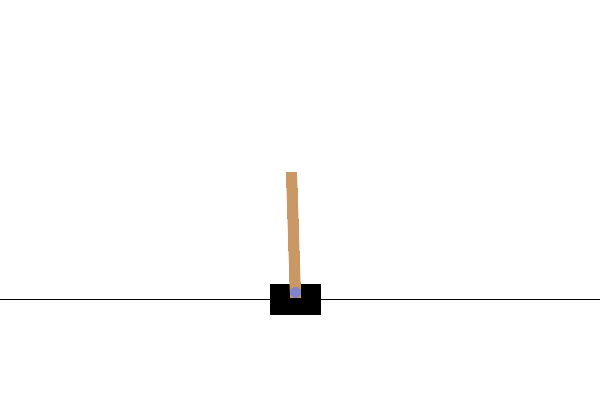

In [13]:
env.reset()
PIL.Image.fromarray(env.render())

In [20]:
print('Observation Spec:')
print(env.time_step_spec().observation)

print('Reward Spec:')
print(env.time_step_spec().reward)

print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


# Let's print one step

In [29]:
result = env.reset()
print("First Step :")
print(result)
print()
print()


# Take action
action = random.choice([0,1])
result = env.step(action)

print("After one step :")
print(result)

First Step :
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.00568601,  0.02703665,  0.01302008, -0.02795658], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})


After one step :
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.00514527,  0.22196949,  0.01246095, -0.31650326], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [31]:
# Create 2 environments, one for training, the other one for evaluation
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# This is just to make sure the numpy arrays are converted into tensorflow tensors
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Creation of the Q-Network

In [33]:
# This means we have one hidden layer with 100 neurons
fc_layer_params = (100,)

# We create the q-network with the parameters, observation vector, and action space
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)


In [ ]:
# Other architecture possible

fc_layer_params = (50, 50)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)


# Optimization part

In [36]:
# Creation of the Adam Optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

# Integer step COunter
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


In [37]:
# During training, the model alternates between 2 policies, the reference policy (learned so far) and the policy for exploration.

# The algorithm uses eval_policy as the main policy for evaluation and development
eval_policy = agent.policy

# The algorithm uses this policy for data collection
collect_policy = agent.collect_policy


In [38]:
# This is the policy that chooses a random action
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())


In [43]:
# Create an environment and set up the random policy
example_environment = tf_py_environment.TFPyEnvironment(suite_gym.load('CartPole-v0'))
time_step = example_environment.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

# Metrics and Evaluation

In [57]:
def compute_avg_return(env, policy, num_episodes = 10):
  # initialize return
  total_return = 0.0
  for _ in range(num_episodes):
    time_step = env.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action = policy.action(time_step)
      time_step = env.step(action)
      episode_return += time_step.reward

    total_return += episode_return
  
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [58]:
# One example
compute_avg_return(eval_env, random_policy, num_eval_episodes)

28.1

# Replay Buffer

The Replay Buffer is a memory that stores experiences an agent has had while interacting with its environment. 

It stores these experiences as trajectories (series of observations, actions, rewards)

During training the agent randomly samples trajectories from the replay buffer and uses them to update its policy or Q-network.

This helps the agent to learn from a diverse set of experiences and avoid overfitting to recent experiences.


In [59]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)


In [60]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

# Data Collection

In [61]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, \
                                      next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)


def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)


collect_data(train_env, random_policy, replay_buffer, steps=100)

In [62]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [63]:
iterator = iter(dataset)

print(iterator)


# Load Policy

In [ ]:
saved_policy = tf.saved_model.load(saved_model_dir)

# Training

In [64]:
# (Optional) Optimize by wrapping some of the code in a graph
# using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy,
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and 
    # save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update 
    # the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy,
                                        num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 25.626787185668945
step = 400: loss = 8.73616886138916
step = 600: loss = 11.116098403930664
step = 800: loss = 13.021650314331055
step = 1000: loss = 1.685867428779602
step = 1000: Average Return = 12.0
step = 1200: loss = 1.7691091299057007
step = 1400: loss = 9.256731033325195
step = 1600: loss = 12.382473945617676
step = 1800: loss = 13.80690860748291
step = 2000: loss = 25.34030532836914
step = 2000: Average Return = 36.400001525878906
step = 2200: loss = 35.034088134765625
step = 2400: loss = 49.09223937988281
step = 2600: loss = 26.08242416381836
step = 2800: loss = 40.97002029418945
step = 3000: loss = 29.08995246887207
step = 3000: Average Return = 55.400001525878906
step = 3200: loss = 20.75833511352539
step = 3400: loss = 17.51983070373535
step = 3600: loss = 136.6868133544922
step = 3800: loss = 33.893035888671875
step = 4000: loss = 51.873291015625
step = 4000: Average Return = 84.4000015258789
step = 4200: loss = 72.65611267089844
step = 4400: loss = 6.

# Visualization and Plots

(2.5999999999999996, 250.0)

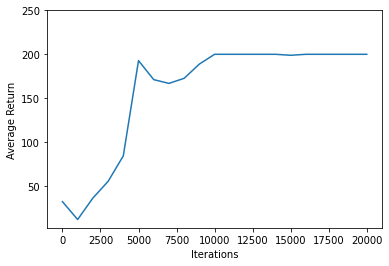

In [65]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

# Videos

In [66]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


In [67]:
# HIDE OUTPUT
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)


create_policy_eval_video(agent.policy, "trained-agent")


In [68]:
# HIDE OUTPUT
create_policy_eval_video(random_policy, "random-agent")


# Save Policy

In [69]:
import os
saved_model_dir = os.path.join(os.getcwd(), 'saved_model')
tf.saved_model.save(agent.policy, saved_model_dir)


In [ ]:
# To download the folder containting the model from Google Collab
!zip -r saved_model.zip saved_model
from google.colab import files
files.download('saved_model.zip')
